In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
import os
warnings.filterwarnings('ignore')

In [40]:
stock_symbol = 'FB' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='10y', interval='1d')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data_training_size = int(len(data)*0.7)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data.shape

[*********************100%***********************]  1 of 1 completed


(1673, 5)

In [41]:
def create_gaf(timeseries):
    data = dict()
    gadf = GramianAngularField(method='difference', image_size=timeseries.shape[0])
    data['gadf'] = gadf.fit_transform(pd.DataFrame(timeseries).T)[0]
    return data['gadf']

In [42]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

x_train.shape, y_train.shape

((1613, 60, 5), (1613,))

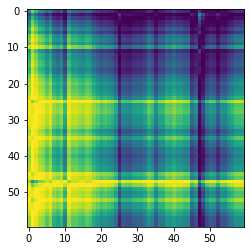

In [43]:
gadfImage = create_gaf(x_test[0]) # first image
plt.imshow(gadfImage, interpolation='nearest')
plt.show()

In [44]:
gadf_training = []

for i in x_train:
    gadf_training.append(create_gaf(i))
gadf_training = np.array(gadf_training)

gadf_training.shape

(1613, 60, 60)

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(60,60,1)),
    keras.layers.Dropout(0.5), # 50% dropout
    keras.layers.Dense(3000, activation='relu'),
    keras.layers.Dropout(0.5), # 50% dropout
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dropout(0.5), # 50% dropout
    keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3000)              10803000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [46]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
model.fit(gadf_training, y_train, epochs=100, batch_size=32)

Epoch 1/100
 1/51 [..............................] - ETA: 13s - loss: 3.3590

2021-11-16 13:58:27.913566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 1s 21ms/step - loss: 11.4654
Epoch 2/100
51/51 [==============================] - 1s 19ms/step - loss: 0.3258
Epoch 3/100
51/51 [==============================] - 1s 20ms/step - loss: 0.1188
Epoch 4/100
51/51 [==============================] - 1s 20ms/step - loss: 0.1086
Epoch 5/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0947
Epoch 6/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0925
Epoch 7/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0873
Epoch 8/100
51/51 [==============================] - 1s 19ms/step - loss: 0.0891
Epoch 9/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0823
Epoch 10/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0804
Epoch 11/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0798
Epoch 12/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0802
Epoch 13/100
51/51 [================

In [47]:
past_window_days = data_training.tail(window)
df = past_window_days.append(data_test, ignore_index = True)
df

,Open,High,Low,Close,Volume
0,155.399994,159.460007,155.009995,158.779999,19180100
1,159.559998,160.490005,157.949997,159.419998,17592000
2,158.509995,158.660004,153.279999,154.919998,21675100
3,155.860001,157.350006,153.550003,154.050003,19761300
4,154.759995,157.339996,154.460007,154.779999,15424700
...,...,...,...,...,...
773,332.489990,333.190002,325.510010,327.640015,21872600
774,329.820007,332.459991,327.000000,327.739990,12376600
775,330.179993,341.859985,329.779999,340.890015,25387200
776,344.339996,353.649994,343.200012,347.559998,25059000


In [48]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction
inputs

array([[0.69479859, 0.7047168 , 0.69875962, 0.70606197, 0.02337125],
       [0.71584698, 0.70985779, 0.71370473, 0.70926565, 0.02057364],
       [0.71053427, 0.70072377, 0.68996541, 0.68673974, 0.02776646],
       ...,
       [1.57913373, 1.6151235 , 1.5871797 , 1.61766038, 0.03430572],
       [1.65077917, 1.67397056, 1.65539856, 1.65104869, 0.03372756],
       [1.64819867, 1.63903171, 1.64355423, 1.62702112, 0.00612884]])

In [49]:
x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((718, 60, 5), (718,))

In [34]:
# transfor flattened data into gaf

gadf_test = []

for i in x_test:
    gadf_test.append(create_gaf(i))
gadf_test = np.array(gadf_test)

gadf_test.shape

(718, 60, 60)

In [35]:
y_pred = model.predict(gadf_test)
y_pred

array([[0.30043298],
       [0.30434242],
       [0.2996613 ],
       [0.29952574],
       [0.2709869 ],
       [0.25945768],
       [0.24271053],
       [0.23903447],
       [0.23818627],
       [0.26148948],
       [0.28030768],
       [0.25546485],
       [0.26952893],
       [0.35948324],
       [0.39816308],
       [0.45410115],
       [0.49714813],
       [0.5433841 ],
       [0.59680855],
       [0.59850925],
       [0.60285604],
       [0.5200356 ],
       [0.489587  ],
       [0.5304862 ],
       [0.5204432 ],
       [0.53509855],
       [0.46821293],
       [0.4655112 ],
       [0.40988612],
       [0.381484  ],
       [0.37366673],
       [0.35835955],
       [0.34181422],
       [0.35037932],
       [0.3550471 ],
       [0.3444455 ],
       [0.34839493],
       [0.34261537],
       [0.34643656],
       [0.358137  ],
       [0.37309426],
       [0.3930108 ],
       [0.42821318],
       [0.4687565 ],
       [0.50244164],
       [0.54403114],
       [0.5450524 ],
       [0.544

In [36]:
# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale

(array([4.13342715e-03, 4.20362380e-03, 4.13718934e-03, 4.20185739e-03,
        1.40474495e-08]),
 0.00413342714948177,
 241.92999267578125)

In [37]:
y_pred_final = y_pred*scale
y_test_final = y_test*scale
# normal scales
y_test_final

array([  2.25      ,   6.25999451,   9.25      ,   7.19999695,
        10.        ,   9.44999695,   8.52999878,   4.88999939,
         7.72999573,   8.30000305,   8.33999634,   6.47000122,
        25.8500061 ,  26.08999634,  25.94999695,  29.3999939 ,
        31.44999695,  28.44999695,  24.72000122,  28.1499939 ,
        27.11000061,  25.63000488,  23.44000244,  24.75999451,
        20.75      ,  22.5       ,  22.17999268,  20.83000183,
        23.32000732,  24.58999634,  23.1499939 ,  22.61999512,
        22.8500061 ,  24.1499939 ,  27.61999512,  33.1499939 ,
        31.75      ,  26.44999695,  31.8500061 ,  32.33999634,
        32.57000732,  30.00999451,  27.41000366,  23.82000732,
        21.72999573,  21.75      ,  25.13999939,  25.8999939 ,
        23.25      ,  27.6000061 ,  28.1000061 ,  24.82000732,
        26.63999939,  28.08000183,  30.38999939,  34.75      ,
        36.27000427,  37.13000488,  35.46000671,  35.86999512,
        38.42999268,  38.49000549,  38.25      ,  38.75

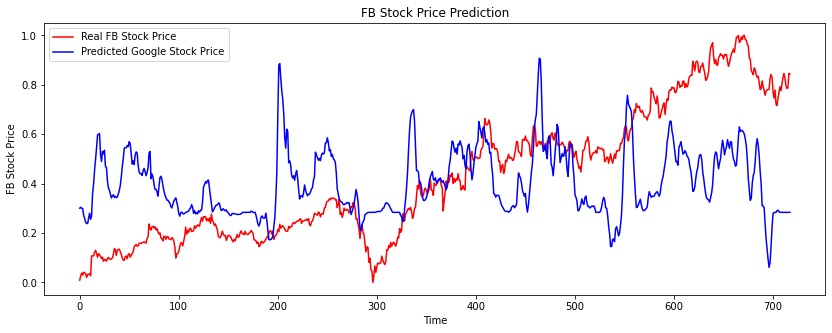

In [38]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real FB Stock Price')
plt.plot(y_pred, color='blue', label='Predicted Google Stock Price')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()